# This is a notebook for testing diff models and architectures 
checked into git because im too lazy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.vae.vae_t import OsuReplayTVAE

osu! path: None/../Local/osu!


In [3]:
model = OsuReplayTVAE.load("replaytvae_morerecent.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'replaytvae_morerecent.pt'

In [4]:
model.plot_error()

In [3]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm.auto as tqdm

import osu.dataset as dataset

from models.annealer import Annealer
from models.base import OsuModel
from models.model_utils import TransformerArgs
from models.vae.encoder_t import ReplayEncoderT



class ReplayDecoder_Lstm(nn.Module):
    def __init__(self, input_size, latent_dim=32, past_frames=0, future_frames=0):
        super().__init__()
        self.past_frames = past_frames
        self.future_frames = future_frames
        self.window_size = past_frames + 1 + future_frames

        combined_size = (input_size) + latent_dim

        # Symmetric layers to encoder (not really almost)
        self.lstm = nn.LSTM(combined_size, 256, num_layers=2, batch_first=True, dropout=0.3)

        self.dense1 = nn.Linear(256, 128)
        self.dense2 = nn.Linear(128, 64)

        self.output_layer = nn.Linear(64, 2)  # x, y positions

    def forward(self, beatmap_features, latent_code):
        batch_size, seq_len, _ = beatmap_features.shape

        # beatmap_features is already windowed
        # Expand latent code to sequence length
        latent_expanded = latent_code.unsqueeze(1).expand(-1, seq_len, -1)

        # Combine windowed features with latent code
        x = torch.cat([beatmap_features, latent_expanded], dim=-1)

        lstm_out, _ = self.lstm(x)

        features = F.relu(self.dense1(lstm_out))
        features = F.relu(self.dense2(features))

        positions = self.output_layer(features)

        return positions


# switch from the RNN based VAE to a transformer based one
# TODO! save hyperparam dict
class OsuReplayTVAE_Lstm(OsuModel):
    def __init__(
        self,
        annealer: Annealer = None,
        batch_size=64,
        device=None,
        latent_dim=64,
        transformer_args: TransformerArgs = None,
        noise_std=0.0, 
        frame_window=(40, 90),
        compile: bool = True
    ):
        self.latent_dim = latent_dim
        self.transformer_args = transformer_args or TransformerArgs()
        self.past_frames = frame_window[0]
        self.future_frames = frame_window[1]
        self.noise_std = noise_std
        self.annealer = annealer or Annealer(
            total_steps=10, range=(0, 0.3), cyclical=True, stay_max_steps=5
        )

        super().__init__(
            batch_size=batch_size,
            device=device,
            compile=compile
        )

    def _initialize_models(self, **kwargs):
        self.encoder = ReplayEncoderT(
            input_size=self.input_size,
            latent_dim=self.latent_dim,
            transformer_args=self.transformer_args,
            noise_std=self.noise_std,
            past_frames=self.past_frames,
            future_frames=self.future_frames,
        )
        self.decoder = ReplayDecoder_Lstm(
            input_size=self.transformer_args.embed_dim,
            latent_dim=self.latent_dim,
            past_frames=self.past_frames,
            future_frames=self.future_frames,
        )

    def _initialize_optimizers(self):
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optim.AdamW(
            params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.001
        )


    def _train_epoch(self, epoch, total_epochs, **kwargs):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for i, (batch_x, batch_y_pos) in enumerate(
            tqdm.tqdm(
                self.train_loader,
                disable=True,
                position=1,
                desc=f"Epoch {epoch + 1}/{total_epochs} (Beta: {self.annealer.current()})",
            )
        ):
            self._set_custom_train_status(f"Batch {i}/{len(self.train_loader)}")
            batch_x = batch_x.to(self.device)             # (B, T, features)
            batch_y_pos = batch_y_pos.to(self.device)     # (B, T, pos)

            self.optimizer.zero_grad()

            # Forward pass
            reconstructed, mu, logvar = self.forward(batch_x, batch_y_pos)

            # Compute loss
            total_loss, recon_loss, kl_loss = self.loss_function(
                reconstructed, batch_y_pos, mu, logvar
            )

            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(self.encoder.parameters()) + list(self.decoder.parameters()),
                max_norm=1.0,
            )
            self.optimizer.step()

            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        # Calculate average losses
        avg_total_loss = epoch_total_loss / len(self.train_loader)
        avg_recon_loss = epoch_recon_loss / len(self.train_loader)
        avg_kl_loss = epoch_kl_loss / len(self.train_loader)

        # Step the annealer
        self.annealer.step()

        return {
            "total_loss": avg_total_loss,
            "recon_loss": avg_recon_loss,
            "kl_loss": avg_kl_loss,
        }

    # allow backpropogatino through sampling
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, beatmap_features, positions):
        embeddings, mu, logvar = self.encoder(beatmap_features)

        # Sample latent code
        z = self.reparameterize(mu, logvar)

        reconstructed = self.decoder(embeddings, z)

        return reconstructed, mu, logvar

    # recon + kl term
    def loss_function(self, reconstructed, original, mu, logvar):
        # TODO! am i supposed to avg this? probably?
        recon_loss = F.mse_loss(reconstructed, original, reduction="sum")
        recon_loss /= original.shape[0]

        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kld /= original.shape[0]

        total_loss = recon_loss + self.annealer(kld)

        return total_loss, recon_loss, kld

    def _get_state_dict(self):
        return {
            "encoder": self.encoder.state_dict(),
            "decoder": self.decoder.state_dict(),
            "latent_dim": self.latent_dim,
            "transformer_args": self.transformer_args.to_dict(),
            "noise_std": self.noise_std,
            "input_size": self.input_size,
            "past_frames": self.past_frames,
            "future_frames": self.future_frames,
        }

    def _load_state_dict(self, checkpoint):
        self.encoder.load_state_dict(checkpoint["encoder"])
        self.decoder.load_state_dict(checkpoint["decoder"])

    @classmethod
    def load(cls, path: str, device: Optional[torch.device] = None, **kwargs):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        checkpoint = torch.load(path, map_location=device)
        
        # Load transformer configuration from checkpoint
        transformer_args = TransformerArgs.from_dict(checkpoint["transformer_args"])
        
        vae_args = {
            "latent_dim": checkpoint.get("latent_dim", 64),
            "transformer_args": transformer_args,
            "noise_std": checkpoint.get("noise_std", 0.0),
            "frame_window": (checkpoint.get("past_frames", 40), checkpoint.get("future_frames", 90)),
        }

        instance = cls(device=device, **kwargs, **vae_args)

        instance._load_state_dict(checkpoint)
        instance._set_eval_mode()

        print(f"{cls.__name__} loaded from {path}")
        return instance

    def generate(self, beatmap_data, num_samples=1):
        self._set_eval_mode()

        with torch.no_grad():
            beatmap_tensor = torch.FloatTensor(beatmap_data).to(self.device)

            batch_size = beatmap_tensor.shape[0]

            # sample from prior distribution
            z = torch.randn(batch_size, self.latent_dim, device=self.device)
            embeddings, mu, logvar = self.encoder(beatmap_tensor)
            # z = self.reparameterize(mu, logvar)

            pos = self.decoder(embeddings, z)

        self._set_train_mode()

        return pos.cpu().numpy()

In [17]:
# model = OsuReplayTVAE_Lstm.load("replaytvae_lstm_most_recent.pt")
from models.vae.vae import OsuReplayVAE
# model = OsuReplayVAE()

model = OsuReplayVAE.load(".trained/replayvae_most_recent.pt")

ReplayVAE initialized on cuda
decoder parameters: 631922
encoder parameters: 880416
Total parameters: 1512338
OsuReplayVAE loaded from .trained/replayvae_most_recent.pt


In [13]:
model.train(5)

ValueError: No data loaded. Call load_data() first.

In [171]:
# test training results
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset
import numpy as np
import torch

# display metrics for stuff

test_name = 'ringyou'
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'
test_replay = f'assets/{test_name}_replay.osr'

test_map = bm.load(test_map_path)
test_replay = rp.load(test_replay)
test_mods = test_replay.mods

test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.SEQ_LEN, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)#[:1, :, :]

replay_data = dataset.target_data_single(test_map, test_replay)
replay_data = np.reshape(replay_data, (-1, dataset.SEQ_LEN, len(dataset.OUTPUT_FEATURES)))

print(data.shape)
print(replay_data.shape)

Turning Omoide Shiritori into time series data: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]

torch.Size([11, 2048, 9])
(11, 2048, 4)


MAE: 0.006498833652585745
MSE: 0.00015585416986141354


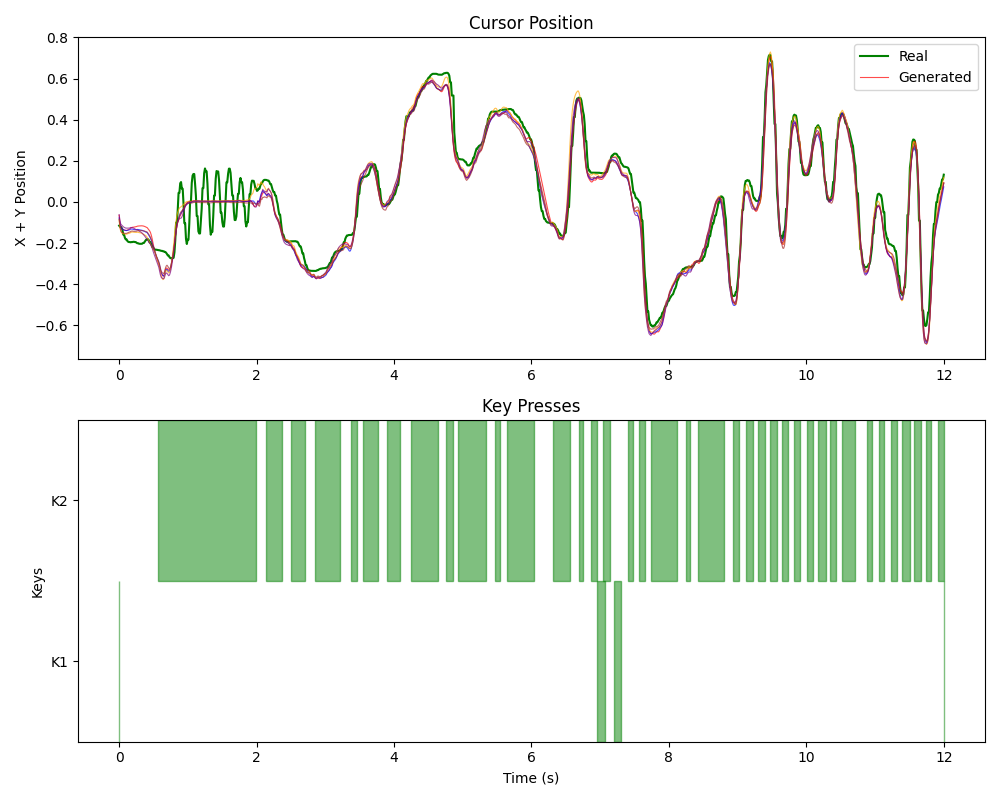

In [188]:
%matplotlib widget
model.display_metrics(data, replay_data, plot_mode="2d", samples=5)

In [112]:
replay_data = model.generate(data)

import os

replay_data = np.concatenate(replay_data)
replay_data = np.pad(replay_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
if not os.path.exists('.generated'):
    os.makedirs('.generated')

print(f"Generated replay data shape: {replay_data.shape}")

replay_data

Generated replay data shape: (11, 2048, 2)


array([[[-0.09229182,  0.01459283],
        [-0.12282158,  0.01382955],
        [-0.13492905,  0.0095324 ],
        ...,
        [-0.35950983, -0.1496111 ],
        [-0.35279205, -0.15605061],
        [-0.34275508, -0.15698715]],

       [[-0.16678114, -0.04860674],
        [-0.27718076, -0.12665567],
        [-0.35114956, -0.17937998],
        ...,
        [-0.27039546,  0.2735026 ],
        [-0.26359788,  0.26501772],
        [-0.25548148,  0.25740778]],

       [[-0.14665537,  0.11235332],
        [-0.23712562,  0.15493065],
        [-0.28418124,  0.1750535 ],
        ...,
        [ 0.05091652,  0.11478315],
        [ 0.00095481,  0.11573146],
        [-0.03432086,  0.11814547]],

       ...,

       [[-0.12570824,  0.13394934],
        [-0.17092136,  0.24283972],
        [-0.207132  ,  0.2820018 ],
        ...,
        [-0.07544897,  0.09483575],
        [-0.06717287,  0.12492575],
        [-0.06681362,  0.13542548]],

       [[-0.05214154,  0.07309681],
        [-0.09137639,  0.11

In [41]:
import osu.preview.preview as preview

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)

/home/niooi/projects/osu-nn/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
